In [2]:
from modelzipper.tutils import *
from metrics import (
    qa_f1_score, rouge_score, classification_score, 
    retrieval_score, count_score, code_sim_score,
)
import numpy as np
import sys
sys.path.insert(0, '/vepfs/wcf/G/zecheng/Retrieval_Head/iclr2025')
from utils.call_llm_api import call_with_messages, api_client, MODEL_ENDPOINT
import multiprocessing
import matplotlib.pyplot as plt

/data/anaconda3/envs/zecheng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2024-08-21 19:15:32


/data/anaconda3/envs/zecheng/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


ModuleNotFoundError: No module named 'utils'

##### 自动评测生成结果 (GPT-4)

In [ ]:
dataset2metric = {
    "narrativeqa": qa_f1_score,
    "qasper_e": qa_f1_score,
    "multifieldqa_en": qa_f1_score,
    "hotpotqa_e": qa_f1_score,
    "2wikimqa_e": qa_f1_score,
    "musique": qa_f1_score,
    "gov_report_e": rouge_score,
    "multi_news_e": rouge_score,
    "trec": classification_score,
    "triviaqa_e": qa_f1_score,
    "samsum_e": rouge_score,
    "passage_retrieval_en": retrieval_score,
    "passage_count": count_score,
    "lcc_e": code_sim_score,
    "repobench-p_e": code_sim_score,
    "qmsum_e": rouge_score,
}


DATASET2CATEGORY = {
    "narrativeqa": "EN Single-Doc QA",
    "qasper_e": "EN Single-Doc QA",
    "multifieldqa_en": "EN Single-Doc QA",
    "multifieldqa_zh": "CN Single-Doc QA",
    "hotpotqa_e": "EN Multi-Doc QA",
    "2wikimqa_e": "EN Multi-Doc QA",
    "musique": "EN Multi-Doc QA",
    "dureader": "CN Multi-Doc QA",
    "gov_report_e": "EN Summarization",
    "qmsum_e": "EN Summarization",
    "multi_news_e": "EN Summarization",
    "vcsum": "CN Summarization",
    "trec": "EN Few-Shot Learning",
    "triviaqa_e": "EN Few-Shot Learning",
    "samsum_e": "EN Few-Shot Learning",
    "lsht": "CN Few-Shot Learning",
    "passage_retrieval_en": "EN Synthetic Task",
    "passage_count": "EN Synthetic Task",
    "passage_retrieval_zh": "CN Synthetic Task",
    "lcc_e": "Code Completion",
    "repobench-p_e": "Code Completion",
}


def instance_scorer(dataset, predictions, answers, all_classes):
    total_scores = []
    instance_scores = []
    for (prediction, ground_truths) in zip(predictions, answers):
        score = 0.
        if '[/INST]' in prediction:
            prediction = prediction.replace('[/INST]', '')
        if dataset in ["trec", "triviaqa_e", "samsum_e", "lsht"]:
            prediction = prediction.lstrip('\n').split('\n')[0]
        for ground_truth in ground_truths:
            score = max(score, dataset2metric[dataset](prediction, ground_truth, all_classes=all_classes))
        total_scores.append(score)
        instance_scores.append((score, prediction, ground_truths))
    return round(100 * sum(total_scores) / len(predictions), 2), instance_scores


def judge_with_llm(pred, golden):
    template = '''You will be provided with a model prediction ##Pred and a golden answer ##Golden. Please judge the quality of the model prediction based on the golden answer from three perspective: 
    1. Hallucination: Does the model prediction contain any hallucination, especially the entity in the predictions not in the goldens? (Yes/No)
    2. Partical Correct: Does the model prediction contains partial information of the golden answer, or most of them are similar? (Yes/No)
    3. Full Correct: Does the model prediction contains the full information of the golden answer? (Yes/No)
    
    Example 1: 
    ##Pred: The capital of China is Beijing 
    ##Golden: The capital of China is Beijing
    ##Answer: No, No, Yes
    
    Example 2:
    ##Pred: Bob and Alice are friends
    ##Golden: Bob and Mike are friends
    ##Answer: Yes, Yes, No

    Example 3:
    ##Pred: Bob and Alice are friends
    ##Golden: Mike and Jack are friends
    ##Answer: Yes, No, No

    Example 4:
    ##Pred: Bob and Alice are friends
    ##Golden: Bob is Alice's friend
    ##Answer: No, Yes, No

    Below is the prediction and golden answer, please judge directly and return three answers directly.
    ##Pred: {pred}
    ##Golden: {golden}
    ##Answer:
    '''

    judge_res = call_with_messages(api_client, MODEL_ENDPOINT['doubao-pro-4k'], template.format(pred=pred, golden=golden), max_attempts=5, max_new_tokens=32)
    return judge_res


def post_process_llm_judge_res(llm_judge_res):
    try:
        llm_judge_res = llm_judge_res.strip()
        llm_judge_res = llm_judge_res.split(',')
        h, p, r = llm_judge_res[0].strip(), llm_judge_res[1].strip(), llm_judge_res[2].strip()
        h = 1 if h.lower() == 'yes' else 0
        p = 1 if p.lower() == 'yes' else 0
        r = 1 if r.lower() == 'yes' else 0
        return (h, p, r)
    except:
        return None

def process_data(filename, sample_num, pred_dir, data_classes, analysis_tasks, result_queue):
    dataset_name = filename.split('.')[0]
    if DATASET2CATEGORY[dataset_name] not in analysis_tasks:
        return
    
    pred_res = auto_read_data(f'{pred_dir}/{dataset_name}.jsonl')
    predictions = [x['pred_str'] for x in pred_res]
    answers = [x['answers'] for x in pred_res]
    avg_score, instance_scores = instance_scorer(dataset_name, predictions, answers, data_classes[dataset_name])
    instance_scores = sorted(instance_scores, key=lambda x: x[0], reverse=False)
    cnt_ins_below_avg = sum([1 for x in instance_scores if x[0] < avg_score])
    selected_num = min(sample_num, cnt_ins_below_avg)
    selected_ins = instance_scores[:selected_num]
    
    llm_judge_res = []
    
    # 使用tqdm创建进度条
    with tqdm(total=len(selected_ins), desc=f"Processing {dataset_name}", position=multiprocessing.current_process()._identity[0]) as pbar:
        for ins in selected_ins:
            pred, golden = ins[1], ins[2]
            raw_judge_res = judge_with_llm(pred, golden)
            judge_res = post_process_llm_judge_res(raw_judge_res)
            if judge_res is None:
                continue
            llm_judge_res.append({'pred': pred, 'golden': golden, 'judge_res': judge_res, 'raw_judge_res': raw_judge_res})
            pbar.update(1)
    
    result_queue.put((dataset_name, llm_judge_res))


## extract all golden data classes
data_classes = {}
benchmark_dataset_path = '/vepfs/wcf/G/zecheng/Retrieval_Head/iclr2025/evaluation/data'
all_benchmark_data_files = os.listdir(benchmark_dataset_path)
for f in all_benchmark_data_files:
    data_name = f.split('.')[0]
    content = auto_read_data(os.path.join(benchmark_dataset_path, f))
    data_classes[data_name] = content[0]["all_classes"]

analysis_tasks = ['EN Single-Doc QA', 'EN Multi-Doc QA', 'EN Synthetic Task']
sample_num = 100
llama2_80k_pred_dir = '/vepfs/wcf/G/zecheng/Retrieval_Head/iclr2025/evaluation/longbench/llama2-80k'
all_pred_files = os.listdir(llama2_80k_pred_dir)

manager = multiprocessing.Manager()
result_queue = manager.Queue()
processes = []

for filename in all_pred_files:
    if filename.endswith("jsonl"):
        p = multiprocessing.Process(target=process_data, args=(filename, sample_num, llama2_80k_pred_dir, data_classes, analysis_tasks, result_queue))
        processes.append(p)
        p.start()

for p in processes:
    p.join()

all_pred_res = {}
while not result_queue.empty():
    dataset_name, llm_judge_res = result_queue.get()
    all_pred_res[dataset_name] = llm_judge_res

Processing hotpotqa_e:  89%|████████▉ | 89/100 [00:59<00:07,  1.49it/s]


##### 合并所有的生成结果

##### 生成概念的解释图

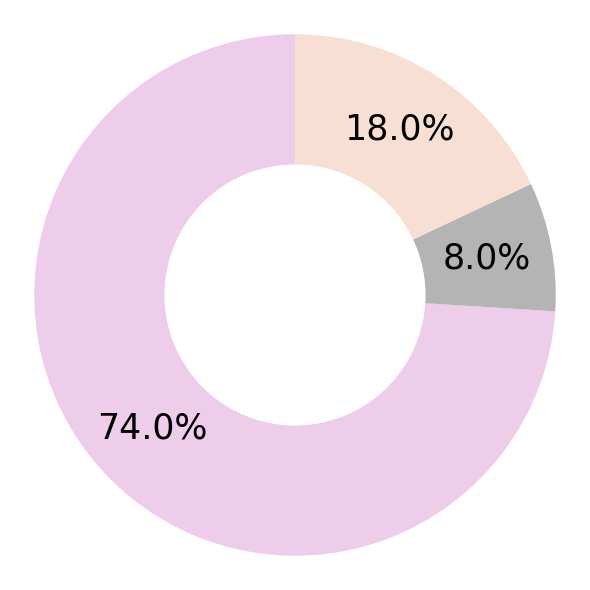

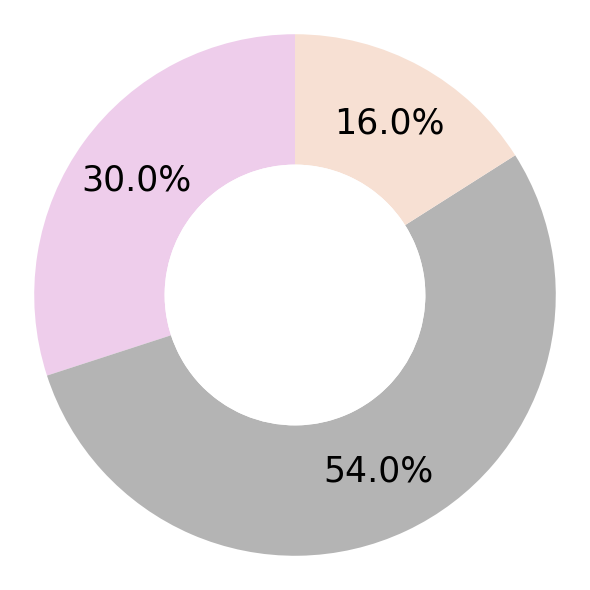

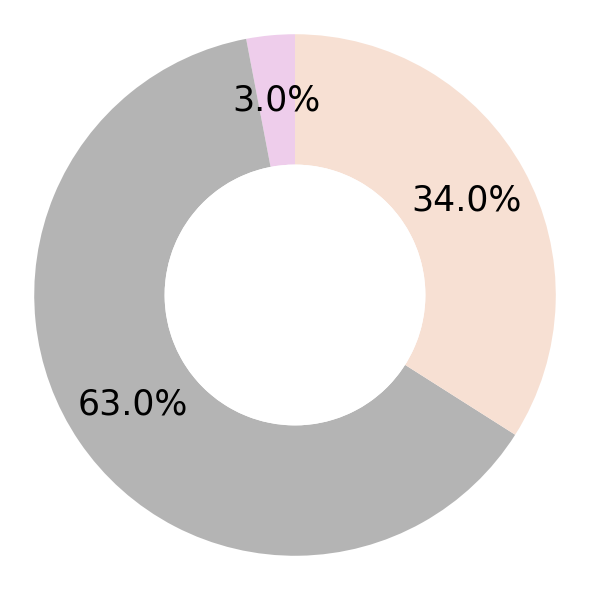

In [29]:
colors = {
    'Hallucination': '#eecdeb',
    'Wrong': '#f7e0d3',
    'Partial Correct': '#b4b4b4',
} # Sky Blue, Light Salmon (soft orange), Dark Sea Green

def plot_circle(d, labels = ['Hallucination', 'Partical Correct', 'Wrong'], save_path=None, font_size=14):
    c = [colors[k] for k in d.keys()]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create the donut chart
    wedges, texts, autotexts = ax.pie(list(d.values()), colors=c, autopct='%1.1f%%', startangle=90, pctdistance=0.75, wedgeprops=dict(width=0.5))
    for autotext in autotexts:
        autotext.set_fontsize(font_size)

    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    # Add a title
    # plt.title("Donut Chart", fontsize=16)

    # Adjust the legend
    # plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Show the plot
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()


mistral_merged_res = {
    'EN Single-Doc QA': [82,2,16],
    'EN Multi-Doc QA': [37,44,19],
    'EN Synthetic Task': [9,43,48]
}  # ['Hallucination', 'Partical Correct', 'Wrong']

llama_3_merged_res = {
    'EN Single-Doc QA': [74, 8, 18],
    'EN Multi-Doc QA': [30, 54, 16],
    'EN Synthetic Task': [3, 63, 34]
}  # ['Hallucination', 'Partical Correct', 'Wrong']

for task in llama_3_merged_res:
    plot_circle({k: llama_3_merged_res[task][i] for i, k in enumerate(['Hallucination', 'Partial Correct', 'Wrong'])}, font_size=25)

# tmp = {'EN Single-Doc QA': [149, 9, 7]}
# plot_circle(tmp, font_size=16)